In [1]:
#Basic Python Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import time
import warnings
warnings.filterwarnings("ignore") 
#Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#Scikit-Learn (Machine Learning Library for Python)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#Evaluation Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
import spacy

In [2]:
# Loading the csv files into dataframds
dev = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv')
train = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv')
test = pd.read_csv('../input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv')

In [3]:
#dev.head()
#train.head()
test.head()


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [4]:
# We will work with only two dataframes- one for training and other for testing
train_dev = pd.concat([train,dev])
train_dev

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
1104,1174,No.,Monica,sadness,negative,113,9,6,2,"00:19:28,792","00:19:29,876"
1105,1175,What? Oh my God! Im gonna miss you so much!,Rachel,sadness,negative,113,10,6,2,"00:19:33,213","00:19:35,965"
1106,1176,Im gonna miss you!,Monica,sadness,negative,113,11,6,2,"00:19:36,175","00:19:37,967"
1107,1177,I mean its the end of an era!,Rachel,sadness,negative,113,12,6,2,"00:19:39,094","00:19:40,928"


In [5]:
# Since we have concatenated the dataframes, resetting the indexes of the new one
train_dev.reset_index(inplace=True,drop=True)

In [6]:
# We will need only two columns for our sentiment analysis
sent = train_dev[['Utterance','Sentiment']]

In [7]:
# For our ML model to understand we will map the sentiments to numbers
def custom_encoder(df):
    df.replace(to_replace ="positive", value = 1, inplace=True)
    df.replace(to_replace ="neutral", value = 0, inplace=True)
    df.replace(to_replace ="negative", value = -1, inplace=True)

In [8]:
#Calling the funtion to encode the sentiments column
custom_encoder(sent['Sentiment'])

In [9]:
#Creating an object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [10]:
# Function to preprocess text column to remove any characters other than alphabets, lemmatize the text, convert to lowercase
def data_preprocessing(text_col):
    corpus = []
    for row in text_col:
        new_row = re.sub('[^a-zA-Z]',' ',str(row)).lower().split()
        new_row = [lm.lemmatize(word) for word in new_row if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_row))
    return corpus

In [11]:
transformed = data_preprocessing(sent['Utterance'])

In [12]:
#transformed

In [13]:
# In the above data preprocessing step there were some empty strings. 
#Creating a dataframe to deal and remove those empty strings
tr_df = pd.DataFrame(zip(transformed,sent['Sentiment']), columns= ['Utterance','Sentiment'])

In [14]:
#Function to get the indices of the empty strings
def get_idx(df):   
    indexes = []
    for i,dialogue in enumerate(df):
        if len(dialogue) == 0:
            empty = df.index
            #print(empty)
            indexes.append(i)
    return indexes

In [15]:
empty_idx = get_idx(tr_df['Utterance'])

In [16]:
#Dropping the empty strings
clean_df = tr_df.drop(empty_idx)
clean_df.reset_index()

,index,Utterance,Sentiment
0,0,also point person company transition kl gr system,0
1,1,must hand full,0
2,3,let talk little bit duty,0
3,4,duty right,1
4,5,heading whole division lot duty,0
...,...,...,...
10535,11092,mean gonna live together anymore,-1
10536,11094,oh god gonna miss much,-1
10537,11095,gonna miss,-1
10538,11096,mean end era,-1


In [17]:
text = clean_df['Utterance'].to_list()

In [18]:
#clean_df['Sentiment'].value_counts()

## Using TFIDF

In [19]:
# Creating an instance of TFIDF
vectorizer = TfidfVectorizer(use_idf=True, norm= 'l1', ngram_range=(2,2))
traindata = vectorizer.fit_transform(text)

In [20]:
#len(vectorizer.get_feature_names())
#traindata

In [21]:
# Parameters for Gridsearch
parameters = {'n_estimators': [100,150,200],
             'max_depth': [30,40,50],
             'min_samples_split': [15,20,30],
             'min_samples_leaf': [2, 5]
             }

In [22]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(traindata,clean_df['Sentiment'])
grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 30,
 'n_estimators': 150}

In [23]:
# Implementing Random Forest
rfc = RandomForestClassifier(max_depth=grid_search.best_params_['max_depth'],
                             n_estimators=grid_search.best_params_['n_estimators'],
                             min_samples_split=grid_search.best_params_['min_samples_split'],
                             min_samples_leaf=grid_search.best_params_['min_samples_leaf']
                            )
rfc.fit(traindata,clean_df['Sentiment'])

RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=30,
                       n_estimators=150)


from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.75)
nb.fit(traindata,clean_df['Sentiment'])

In [24]:
# Working with test dataset
test_df = test[['Utterance','Sentiment']]
X_test,y_test = test_df['Utterance'],test_df['Sentiment']


In [25]:
#Pre-processing text data
test_transformed = data_preprocessing(X_test)
test_tr_df = pd.DataFrame(zip(test_transformed,test['Sentiment']), 
                                   columns= ['Utterance','Sentiment'])
empty_test_idx = get_idx(test_tr_df['Utterance'])
clean_test_df = test_tr_df.drop(empty_test_idx)

#Convert text data into vectors
test_text = clean_test_df['Utterance'].to_list()
testdata = vectorizer.transform(test_text)
X_test,y_test = clean_test_df['Utterance'],clean_test_df['Sentiment']

#Encode the labels into three classes 0, 1, and -1
custom_encoder(y_test)

In [26]:
#predict the target
predictions = rfc.predict(testdata)

### Evaluating the results

Accuracy_score:  0.499
Precision_score:  0.66
Recall_score:  0.5
-------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.70      0.05      0.09       781
           0       0.49      1.00      0.66      1203
           1       1.00      0.01      0.02       505

    accuracy                           0.50      2489
   macro avg       0.73      0.35      0.26      2489
weighted avg       0.66      0.50      0.35      2489



<Figure size 864x576 with 0 Axes>

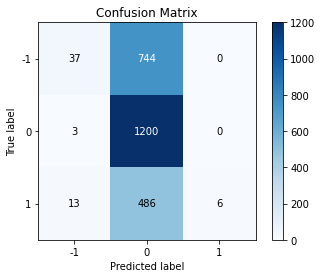

In [27]:
# Calculating Accuracy, Precision, and Recall scores
plt.figure(figsize = (12,8))
plot_confusion_matrix(y_test,predictions)
acc_score = round(accuracy_score(y_test,predictions),3)
pre_score = round(precision_score(y_test,predictions,average='weighted'),2)
rec_score = round(recall_score(y_test,predictions,average='weighted'),2)

print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score )
print('Recall_score: ',rec_score)
print("-"*55)

# Generating Classification Report
cr = classification_report(y_test,predictions)
print(cr)